# Big Mart Sales Prediction

<u>**Assignment Objective**</u>: Given a training dataset (~8k rows), predict product sales for the given test dataset (~5k rows)

<u>**Notebook Objective**</u>: Explore different ML models, tune hyperparameters, optimize the best performing model further

**Content**:
1. Data Import
2. Model Tuning Setup
3. Model Inference and CV Scores
4. Additional Optimization

In [1]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

## Data Import

In [2]:
df_train_ohe = pd.read_csv('../data/df_train_ohe.csv',index_col=0)
df_test_ohe = pd.read_csv('../data/df_test_ohe.csv',index_col=0)

df_train_cat = pd.read_csv('../data/df_train_cat.csv',index_col=0)
df_test_cat = pd.read_csv('../data/df_test_cat.csv',index_col=0)

# Importing original test data set to get the item and outler IDs for submission
test = pd.read_csv('../data/test.csv')

In [3]:
# X,y for regular models
X_ohe = df_train_ohe.drop(['Item_Outlet_Sales'],axis=1)
y_ohe = df_train_ohe['Item_Outlet_Sales']

# X,y for CatBoost model
X_cat = df_train_cat.drop(['Item_Outlet_Sales'],axis=1)
y_cat = df_train_cat['Item_Outlet_Sales']

Checking if the data is as we expected it after exporting from EDA notebook:

In [4]:
X_ohe.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_ID,Outlet_Age,price/weight,Outlet_Identifier_HIGH,Outlet_Identifier_LOW,Outlet_Identifier_MED,Item_MRP_Group_A,Item_MRP_Group_B,Item_MRP_Group_C,Item_MRP_Group_D
0,9.30,0,-4.132215,249.8092,1,1,1,2,14,26.861204,0,0,1,0,0,0,1
1,5.92,1,-3.948780,48.2692,1,3,2,0,4,8.153581,0,0,1,1,0,0,0
2,17.50,0,-4.088756,141.6180,1,1,1,2,14,8.092457,0,0,1,0,0,1,0
3,19.20,1,-4.181625,182.0950,0,3,0,2,15,9.484115,0,1,0,0,0,1,0
4,8.93,0,-4.818097,53.8614,2,3,1,1,26,6.031512,0,0,1,1,0,0,0


In [5]:
X_cat.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_ID,Outlet_Age,Item_MRP_Group,price/weight
0,9.30,Low Fat,-4.132215,249.8092,MED,Medium,Tier 1,Supermarket Type1,FD,14,D,26.861204
1,5.92,Regular,-3.948780,48.2692,MED,Medium,Tier 3,Supermarket Type2,DR,4,A,8.153581
2,17.50,Low Fat,-4.088756,141.6180,MED,Medium,Tier 1,Supermarket Type1,FD,14,C,8.092457
3,19.20,Regular,-4.181625,182.0950,LOW,Small,Tier 3,Grocery Store,FD,15,C,9.484115
4,8.93,Low Fat,-4.818097,53.8614,MED,High,Tier 3,Supermarket Type1,NC,26,A,6.031512


In [6]:
df_test_ohe.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_ID,Outlet_Age,price/weight,Outlet_Identifier_HIGH,Outlet_Identifier_LOW,Outlet_Identifier_MED,Item_MRP_Group_A,Item_MRP_Group_B,Item_MRP_Group_C,Item_MRP_Group_D
0,20.750,0,-4.884245,107.8622,1,1,1,2,14,5.198178,0,0,1,0,1,0,0
1,8.300,1,-3.258977,87.3198,0,2,1,2,6,10.520458,0,0,1,0,1,0,0
2,14.600,0,-2.306845,241.7538,0,3,0,1,15,16.558479,0,1,0,0,0,0,1
3,7.315,0,-4.174142,155.0340,0,2,1,2,6,21.193985,0,0,1,0,0,1,0
4,13.600,1,-2.132005,234.2300,1,3,3,2,28,17.222794,1,0,0,0,0,0,1


In [7]:
df_test_cat.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_ID,Outlet_Age,Item_MRP_Group,price/weight
0,20.750,Low Fat,-4.884245,107.8622,MED,Medium,Tier 1,Supermarket Type1,FD,14,B,5.198178
1,8.300,Regular,-3.258977,87.3198,MED,Small,Tier 2,Supermarket Type1,FD,6,B,10.520458
2,14.600,Low Fat,-2.306845,241.7538,LOW,Small,Tier 3,Grocery Store,NC,15,D,16.558479
3,7.315,Low Fat,-4.174142,155.0340,MED,Small,Tier 2,Supermarket Type1,FD,6,C,21.193985
4,13.600,Regular,-2.132005,234.2300,HIGH,Medium,Tier 3,Supermarket Type3,FD,28,D,17.222794


In [8]:
y_ohe.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [9]:
y_cat.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

Great! Everything looks just like we wanted it to be. Let's proceed with the model selection and tuning.

---

## Model Tuning Setup

We will create a model tuner class with in built hyperparameters for 4 models --> GradientBoost, LightGBM, XGBoost and CatBoost

We will also create objective functions and a run function to optimize the hyperparameters using **optuna**.

Other than that, we are using a **RepeatedKFold** cross-validation to get a robust model with low variance and good generalization.

In [10]:
class ModelTuner:
    def __init__(self, X, y, n_splits=5, n_repeats=5, random_state=42):
        self.X = X
        self.y = y
        self.rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) 
        self.rmse_scorer = make_scorer(self.rmse, greater_is_better=False)

    # Since our metric is RMSE, we'll create a custom scorer here for it
    @staticmethod
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # GradientBoost Objective
    def objective_gb(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            "random_state": 42,
        }
        model = GradientBoostingRegressor(**params)
        scores = cross_val_score(model, self.X, self.y, scoring=self.rmse_scorer, cv=self.rkf, n_jobs=-1)
        return -np.mean(scores)

    # LightGBM Objective
    def objective_lgb(self, trial):
        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            'boosting_type': 'gbdt',
            "random_state": 42,
            "n_jobs": -1,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 5.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 5.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
        }
        model = lgb.LGBMRegressor(**params)
        scores = cross_val_score(model, self.X, self.y, scoring=self.rmse_scorer, cv=self.rkf, n_jobs=-1)
        return -np.mean(scores)

    # XGBoost Objective
    def objective_xgb(self, trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "random_state": 42,
            "n_jobs": -1,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
            "max_leaves": trial.suggest_int("max_leaves", 4, 256)
        }
        model = xgb.XGBRegressor(**params)
        scores = cross_val_score(model, self.X, self.y, scoring=self.rmse_scorer, cv=self.rkf, n_jobs=-1)
        return -np.mean(scores)

    # CatBoost Objective
    def objective_cat(self,trial):
        # Defining the categorical columns. This goes an input to the model.
        cat_cols = ['Item_Fat_Content','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_ID','Item_MRP_Group']
        params = {
            'random_state': 42,
            'loss_function': 'rmse',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int("max_depth", 3, 8),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10.0),
            'max_bin': trial.suggest_int('max_bin', 100, 500),
            'n_estimators':  trial.suggest_int('n_estimators', 500, 1500),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        }
        model = CatBoostRegressor(**params,cat_features=cat_cols)
        scores = cross_val_score(model, self.X, self.y, scoring=self.rmse_scorer, cv=self.rkf, n_jobs=-1)
        return -np.mean(scores)

    # Optimization function
    def run(self, model_name, n_trials):
        mapping = {
            "xgb": self.objective_xgb,
            "gb": self.objective_gb,
            "lgb": self.objective_lgb,
            'cat':self.objective_cat
        }
        
        study = optuna.create_study(direction="minimize")
        study.optimize(mapping[model_name], n_trials=n_trials, n_jobs=-1)
        return study

---

## Model Inference and CV Scores

In this section, I did 10, 20, and 50 trials over these 4 models and found that XGBoost & Catboost were consistently performing better on leaderboard scores. The goal of this section is to make sure that an improvement in CV scores also reflects well on the leaderboard scores. If that doesn't happen, then the model(s) is overfitting the training set and is unable to generalize well.

**Please note:** I have omitted the tuned hyperparameters output and iterations from the notebooks since this work is on a public repository and wanted to avoid misuse of the same in the hackathon. The tuned parameters are stored by me locally for reproducibility and I can provide it privately upon request.

In [58]:
# tuner = ModelTuner(X_ohe, y_ohe)
# study_gb  = tuner.run(model_name="gb", n_trials=50)
# study_lgb = tuner.run(model_name="lgb", n_trials=50)
# study_xgb = tuner.run(model_name="xgb", n_trials=50)

In [ ]:
print(f'BEST CV SCORE for GradientBoosting: {study_gb.best_value:0.2f}')

BEST CV SCORE for GradientBoosting: 1082.34


In [57]:
# gb_best_params = study_gb.best_params
# gb_best_params['random_state'] = 42

# final_model = GradientBoostingRegressor(**gb_best_params)
# final_model.fit(X_ohe,y_ohe)
# y_preds1 = final_model.predict(df_test_ohe)

# submit = test[['Item_Identifier','Outlet_Identifier']].copy()
# submit['Item_Outlet_Sales'] = y_preds1
# submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=0) # Clipping lower bound to 0 since sales cannot be < 0
# submit.to_csv('submission.csv',index=False)

In [ ]:
print(f'BEST CV SCORE for LightGBM: {study_lgb.best_value:0.2f}')

BEST CV SCORE for LightGBM: 1079.56


In [56]:
# lgb_best_params = study_lgb.best_params
# lgb_best_params['objective'] ='regression'
# lgb_best_params['metric'] = 'rmse'
# lgb_best_params['random_state'] = 42
# lgb_best_params['n_jobs'] = -1
# lgb_best_params['verbosity'] = -1
# lgb_best_params['boosting_type'] = 'gbdt'

# final_model = lgb.LGBMRegressor(**lgb_best_params)
# final_model.fit(X_ohe,y_ohe)
# y_preds2 = final_model.predict(df_test_ohe)

# submit = test[['Item_Identifier','Outlet_Identifier']].copy()
# submit['Item_Outlet_Sales'] = y_preds2
# submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=0) # Clipping lower bound to 0 since sales cannot be < 0
# submit.to_csv('submission.csv',index=False)

In [ ]:
print(f'BEST CV SCORE for XGBoost: {study_xgb.best_value:0.2f}')

BEST CV SCORE for XGBoost: 1080.87


In [55]:
# xgb_best_params = study_xgb.best_params
# xgb_best_params['objective'] ='reg:squarederror'
# xgb_best_params['eval_metric'] = 'rmse'
# xgb_best_params['random_state'] = 42
# xgb_best_params['n_jobs'] = -1

# final_model = xgb.XGBRegressor(**xgb_best_params)
# final_model.fit(X_ohe,y_ohe)
# y_preds3 = final_model.predict(df_test_ohe)

# submit = test[['Item_Identifier','Outlet_Identifier']].copy()
# submit['Item_Outlet_Sales'] = y_preds3
# submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=0) # Clipping lower bound to 0 since sales cannot be < 0
# submit.to_csv('submission.csv',index=False)

Now it's time to evaluate Catboost Regressor. This model can handle the categorical columns intrincsically and thus it doesn't require us to do one-hot encoding. This makes it possible to reduce the number of dimensions in the data, which may lead to better scores. The downside of this model is that it takes a very long time to train and thus hyperparameter tuning could be particularly difficult on this model. To deal with that, we will reduce the number of repeats to just 2 from 5 in our model tuner class.

In [54]:
# tuner = ModelTuner(X_cat, y_cat, n_splits=2)
# study_cat = tuner.run(model_name="cat", n_trials=50)

In [ ]:
print(f'BEST CV SCORE for CatBoost: {study_cat.best_value:0.2f}')

BEST CV SCORE for CatBoost: 1080.21


In [53]:
# cat_cols = ['Item_Fat_Content','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_ID','Item_MRP_Group']

# cat_best_params = study_cat.best_params
# cat_best_params['loss_function'] = 'rmse'
# cat_best_params['random_state'] = 42

# final_model = CatBoostRegressor(**cat_best_params,cat_features=cat_cols)
# final_model.fit(X_cat,y_cat)
# y_preds4 = final_model.predict(df_test_cat)

# submit = test[['Item_Identifier','Outlet_Identifier']].copy()
# submit['Item_Outlet_Sales'] = y_preds4
# submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=0) # Clipping lower bound to 0 since sales cannot be < 0
# submit.to_csv('submission.csv',index=False)

Observations:
1. LightGBM has the best CV scores followed by Catboost and XGBoost with GradientBoost being the worst of them
2. Since CV scores are not necessarily representative of how the leaderboard will look, the submissions were made for all 4 models with 10, 20 and 50 trials of hyperparameter tuning.
3. From these trials, XGBoost and CatBoost were found to be performing well in terms of LB scores.

Thus, XGBoost and CatBoost were selected for additional model training and score improvement. On top of that, we will do some additional feature engineering and transformations in the EDA notebook in conjuction with the rigourous model training to improve the score.

---

## Additional Optimization

From our inferences, we have concluded that XGBoost is not only faster to train but also ends up giving a better leaderboard score. On the other hand CatBoost is also giving good LB scores but is much difficult to train. Now we try to improve the hyperparameters further with higher number of trials.

Since this is an iterative process, we will not only perform hyperparameter tuning but also do **addtional feature engineering** in our EDA notebook to see what works and what doesn't.

In [52]:
# tuner = ModelTuner(X_ohe, y_ohe, n_repeats=2)
# study_xgb = tuner.run(model_name="xgb", n_trials=200)

In [51]:
# xgb_best_params = study_xgb.best_params
# xgb_best_params['objective'] ='reg:squarederror'
# xgb_best_params['eval_metric'] = 'rmse'
# xgb_best_params['random_state'] = 42
# xgb_best_params['n_jobs'] = -1

# final_model = xgb.XGBRegressor(**xgb_best_params)
# final_model.fit(X_ohe,y_ohe)
# y_preds_xgb = final_model.predict(df_test_ohe)

# submit = test[['Item_Identifier','Outlet_Identifier']].copy()
# submit['Item_Outlet_Sales'] = y_preds_xgb
# submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=0) # Clipping lower bound to 0 since sales cannot be < 0
# submit.to_csv('submission.csv',index=False)

After numerous trials, loads of feature engineering (adding/removing/modifying) features from the dataset, I am getting a leaderboard RMSE score of roughly 1146 putting me at a RANK of ***259***.

Let's try the same rigourous hyperparameter tuning on CatBoost with our final feature engineering columns selected in the EDA notebook.

In [50]:
# tuner = ModelTuner(X_ohe, y_ohe, n_repeats=2)
# study_cat = tuner.run(model_name="cat", n_trials=200)

In [49]:
# cat_best_params = study_cat.best_params
# cat_best_params['loss_function'] = 'rmse'
# cat_best_params['random_state'] = 42

# final_model = CatBoostRegressor(**cat_best_params,cat_features=cat_cols)
# final_model.fit(X_cat,y_cat)
# y_preds_cat = final_model.predict(df_test_cat)

# submit = test[['Item_Identifier','Outlet_Identifier']].copy()
# submit['Item_Outlet_Sales'] = y_preds_cat
# submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=0) # Clipping lower bound to 0 since sales cannot be < 0
# submit.to_csv('submission.csv',index=False)

**Exploring output clipping**

We know from our EDA that the Item_Sales_Output had some outliers present in the data. The presense of outliers during model training can make the model predict erroneous values. Thus it is advisable to limit the model output to a sensible range that stops the predictions to be wildly different, especially on the higher side.

<Axes: ylabel='Frequency'>

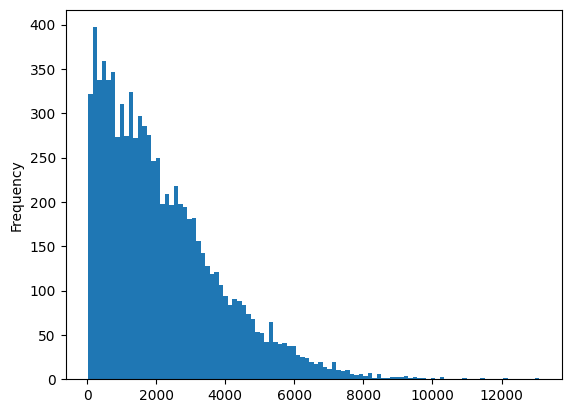

In [25]:
train = pd.read_csv('../data/train.csv')
train.Item_Outlet_Sales.plot(kind='hist',bins=100)

In [26]:
# This was the minimum number of sales seen in the training set. We can keep this as a lower limit
train.Item_Outlet_Sales.min()

np.float64(33.29)

In [27]:
# 95%ile is a good limit to clip the data to remove the effect of outliers on the ML model
train.Item_Outlet_Sales.quantile(0.95)

np.float64(5522.811)

In [ ]:
submit = test[['Item_Identifier','Outlet_Identifier']].copy()
submit['Item_Outlet_Sales'] = y_preds_cat
submit.Item_Outlet_Sales = submit.Item_Outlet_Sales.clip(lower=train.Item_Outlet_Sales.min(),
                                                         upper=train.Item_Outlet_Sales.quantile(0.95))
submit.to_csv('submission.csv',index=False)

Clipping the data with statistically backed values has given is an additional improvement on leaderboard scores. Thus finally with loads of trials, feature engineering and using clipping, we are able to achieve a RMSE of **~1143.45**

As a final effort to improve the model score, we can fine tune the hyperparameters. After manually increasing the n_estimators from 1000 to 1500, we get an additional RMSE boost with the final score now being **~1140.88**

This puts us on a final rank of **44** out of 53k registered participants.

## Future Scope

I have tried model ensembling between the above 4 model but it did not seem to improve the error score. The reason behind it is that I'm using similar types of models that learn in a somewhat similar way (all tree-based)

I think a future scope of this hackathon could be to ensemble different types of regressors --> Linear, Tree-based, SVM, DNNs

On top of that, there are ***stacking and blending*** methods that use the models' outputs and train another ***meta-learner model*** which can find the best way to ensemble the outputs of these models.